# Démarche

### Partie 1 : Analyse des features
Dans un premier temps nous allons analyser la matrice de features sous deux angles :

- Existe-t-il des corrélations entre les différentes colonnes pour supprimer les colonnes redondantes ? La réponse est non. Il n'y a donc pas de colonnes évidentes à supprimer.


- Chaque colonne est-elle du même ordre de grandeur que les autres, afin de voir s'il est nécessaire de normaliser la matrice des features pour faciliter le calcul des différents modèles et dans certains cas améliorer le score. La réponses est oui l'ordre de grandeur est le même. Il n'est donc pas nécessaire de centrer réduire la matrice.

### Partie 2 : Détermination des classifieurs qui semblent le plus adaptés
Nous allons voir quels sont les algorithmes qui ont l'air de faire le moins d'erreurs :

 - Parmis les modèles nous ne testons bien entendu que les modèles de type classifieur à savoir : la régression logistique, le perceptron, les arbres de décision, les forêts aléatoires, le naive bayes, lda, qda, svm, nu svm, K plus proches voisins et les réseaux de neurones
 
 
 - Nous allons définir une fonction de coût : nous choisissons la fonction de coût classique 0/1 (donc sans poids sur les erreurs) le but étant simplement de voir les modèles qui font le moins d'erreurs
 
 
 - Nous allons ensuite choisir comment estimer l'erreur : via une validation croisée. Pour cela il faut diviser le dataset de façon homogène. Le dataset contient d'abord toutes les observations classées en 1, puis ensuite toutes les observations classées en -1. Pour une CV de 5-fold, chaque fold sera alors composé des lignes dont le numéro modulo 5 a la même valeur. Ainsi on s'assure d'un équilibre entre la répartition des -1 et des 1 de chaque fold

- Nous écarterons alors les classifieurs qui ne semblent pas adaptés aux données, pour ne se concentrer que sur les autres

**Conclusion de la partie 2** : Les forêtes aléatoires, les arbres de décision, le perceptron, le naive bayes et le lda ne donnent pas de très bons résultats, nous allons donc optimiser uniquement les autres à savoir les knn, svm, nu svm, mlp, qda et la régression logistique.

### Partie 3 : Optimisation des différents classifieurs déterminés à l'étape 2

Pour chacun des classifieurs il est nécessaire de sélectionner les paramètres qui optimisent le modèle pour les données.

Pour chacun des classifieurs la méthode adoptée pour trouver ces hyper paramètres a été la suivante :
 
 - Définition d'une grille de recherche pour les paramètres
 - Sélection par validation croisée de la plage qui semble la plus appropriée 
 - Puis nouvelle validation croisée sur une grille contenue dans la plage précédente pour déterminer les hyperparamètres de façon précise

Un des points importants qui n'a pas été pris en compte jusqu'à présent est le fait que dans le calcul du score les erreurs coûtent 10 fois plus cher que de ne pas se prononcer. Il est donc nécessaire pour chaque classifieur de savoir à partir de quel seuil il ne doit pas se prononcer, et ce pour optimiser le score.

Nous allons donc tester aussi par validation croisée, sur une grille de recherche, le seuil qui est optimal pour réaliser le meilleur score.

### Partie 4 : Analyse des résultats des différents classifieurs sur le test

A partir de chaque classifieur optimisé (hyperparamètres et seuils à partir duquel le classifieur ne se prononce pas), nous allons générer le fichier des prédictions sur le test, et voir le score obtenu. A partir de ce score, connaissant le nombre de 0 générés, nous pouvons determiner le nombre d'erreurs réalisées sur le test et ainsi voir les meilleurs classifieurs.

** Conclusion de la partie 4 ** : Il en ressort que les nu svm fonctionnent le mieux, viennent ensuite les réseuax de neurones,  les svm et les knn.

### Partie 5 : Combinaison de plusieurs classifieurs

    Solution 1 : Execution des classifieurs "en série"
Dans cette solution nous allons générer le fichier de sortie en combinant les résultats de plusieurs modèles. Le principe est d'executer un modèle, puis pour les données qu'il n'aura pas réussi à classer lancer un autre modèle, et ainsi de suite.

On part du modèle qui a le mieux fonctionné, à savoir le nu SVM, puis on va compléter les zéros avec les résultats des mlp et des knn en utilisant un seuil pour lequel on est presque sûr que ces algorithmes ne fassent pas d'erreur.

    Solution 2 : Execution des classifieurs "en parallèle"
Dans cette solution nous exécutons nos différents modèles en parallèles, nous obtenons donc pour chaque observation autant de prédictions que de modèles.

 - Si pour une observation la moyenne des valeurs prédites est supérieure à 0, on choisit comme étiquette la valeur '1'.

 - Si pour une observation la moyenne des valeurs prédites est inférieure à 0, on choisit comme étiquette la valeur '-1'.

 - Si pour une observation la moyenne des valeurs prédites est autour de 0, on choisit comme étiquette la valeur '0'.

### Partie 6 : Conclusion sans tenir compte des données de tests
La meilleure solution déterminée via les analyses précédentes est un mélange ("en série") des algorithmes suivants :

 - nu svm (nu = 0.12, gamma = 1.05)
 - svm (C = 20000, gamma = 1.05) 
 - mlp (500 couches, alpha = 1e-2)
 - knn (30 voisins, disance = weights).

Le score obtenu sur le test est d'environs 0.15.


### Partie 7 : Overfitting sur les données de test pour améliorer le score
Le but d'un challenge étant d'obtenir le meilleur score sur les données de test, et non pas de généraliser au mieux l'algorithme, il est possible d'overfitter notre algorithme sur les données de test.

J'ai pu remarquer que les K plus proches voisins avec un nombre de voisins élevés (110) fonctionnait très bien sur le test, ainsi que l'algorithme des qda avec ses paramètres par défaut.

En reprenant le principe de mélanger des modèles "en série", et en y ajoutant le modèle des qda et des knn avec 110 voisins, les résultats ont été amélioré pour à environs 0.13.

# Import des données

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from cycler import cycler
from sklearn import datasets

In [2]:
X_fname = '/Users/lolo/Développement/Python/CoursTelecom/MachineLearning/Challenge/data/training_templates.csv'
y_fname = '/Users/lolo/Développement/Python/CoursTelecom/MachineLearning/Challenge/data/training_labels.txt'
X_test_fname  = '/Users/lolo/Développement/Python/CoursTelecom/MachineLearning/Challenge/data/testing_templates.csv'
X = pd.read_csv(X_fname, sep=',', header=None).values
X_test  = pd.read_csv(X_test_fname,  sep=',', header=None).values
y = np.loadtxt(y_fname, dtype=np.int)

# Partie 1 : Analyse des features
### Corrélation et homogénité de l'ordre de grandeur des données

In [5]:
# Analyse de la corrélation entre les colonnes
X_corel = np.corrcoef(X.T)
indice_high_corel = np.where(np.abs(X_corel - np.identity(X_corel.shape[0]))>0.3)
print(indice_high_corel)

(array([], dtype=int64), array([], dtype=int64))


On constate donc qu'aucune colonne n'est corrélée à une autre de plus de 30% on peut donc conclure qu'il n'existe aucune corrélation entre les colonnes, on ne peut donc pas supprimier de features sous prétexte qu'elles sont redondantes

In [6]:
mean = [0] * X.shape[1]
for i in range(X.shape[1]):
    mean[i] = np.mean(np.abs(X[:, i]))
for i in range(len(mean)):
    for j in range(len(mean)):
        if mean[i]/mean[j] > 1.5:
            print("Ratio supérieur à 100")

# Partie 2 : Détermination des classifieurs qui semblent le plus adaptés
### Division des données en training et test set

In [3]:
K = 5

def split_train_test_set(X, y):
    # Définition des données de training, validation et de test
    X_train_K = [0] * K
    y_train_K = [0] * K
    X_test_K = [0] * K
    y_test_K = [0] * K

    # Alimentation des données de training, validation et de test
    # à partir de X et y
    for i in range(K):
        value_K = list(range(K))
        value_K.remove(i)

        # Alimentation des données de test
        X_test_K[i] = X[i::K]
        y_test_K[i] = y[i::K]

        # Alimentation des données de training
        for j in value_K:
            if (type(X_train_K[i]) == int) :
                X_train_K[i] = X[j::K]
                y_train_K[i] = y[j::K]
            else:
                X_train_K[i] = np.append(X_train_K[i], X[j::K], axis=0)
                y_train_K[i] = np.append(y_train_K[i], y[j::K], axis=0)
    
    return X_train_K, y_train_K, X_test_K, y_test_K

### Définition des fonctions de coûts

In [4]:
# Critere de performance
def compute_pred_score(y_true, y_pred):
    y_comp = y_true * y_pred
    score = float(10*np.sum(y_comp == -1) + np.sum(y_comp == 0))
    score /= y_comp.shape[0]
    return score

In [5]:
# Taux d'erreur
def compute_errors(y_true, y_pred):
    y_comp = y_true * y_pred
    score = float(np.sum(y_comp == -1))
    score /= y_comp.shape[0]
    return 100 * score

### Définition d'une fonction qui va nous afficher le résultat sous forme de graphe pour chaque classifieur

In [6]:
def compute_error_for_model(model, X, y): 
    X_train_K, y_train_K, X_test_K, y_test_K = split_train_test_set(X, y)
    
    list_errors_train = [0] * K
    list_errors_test = [0] * K
    list_models = [0] * K
    for i in range(K):
        model.fit(X_train_K[i], y_train_K[i])
        
        y_pred_train =  model.predict(X_train_K[i])
        error_train = compute_errors(y_train_K[i], y_pred_train)
        list_errors_train[i] = error_train
        
        y_pred_test =  model.predict(X_test_K[i])
        error_test = compute_errors(y_test_K[i], y_pred_test)
        list_errors_test[i] = error_test

        list_models[i] = model
    
    return list_errors_train, list_errors_test


def plot_result(list_scores_train, list_scores_test): 
    plt.suptitle('Résultats du modèle', fontsize=12, fontweight='bold')
    plt.xlabel("Numéro du fold")
    plt.ylabel("Erreurs (%)")
    plt.plot(list(range(K)), list_scores_train, 'b', label="train")
    plt.plot(list(range(K)), list_scores_test, 'r', label="test")
    plt.legend(loc="upper left")
    plt.show()

### Test de différents classifieurs

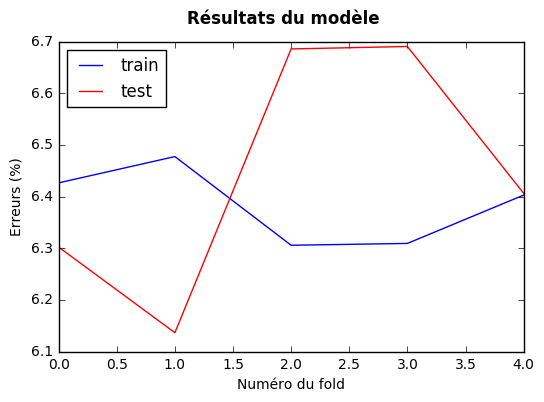

In [304]:
###################################################
# Regression logistique
###################################################
clf = LogisticRegression()
result = compute_error_for_model(clf, X, y)
plot_result(result[0], result[1])

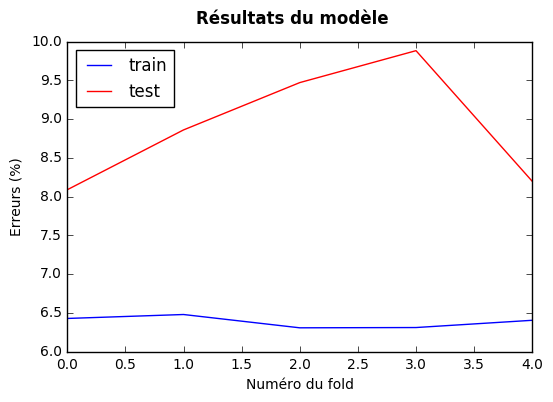

In [265]:
###################################################
# Perceptron
###################################################
clf = Perceptron(n_iter=50)
result = compute_error_for_model(clf, X, y)
plot_result(result[0], result[1])

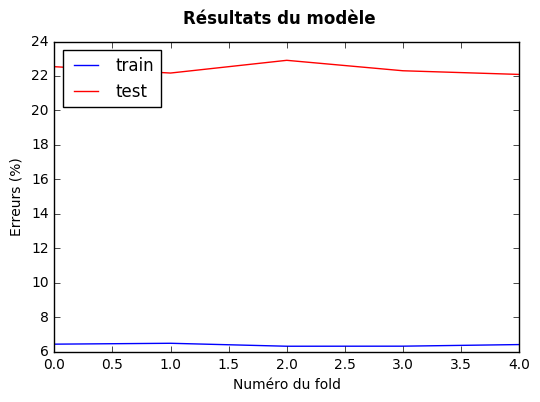

In [266]:
###################################################
# Arbre de décision
##################################################
clf = DecisionTreeClassifier()
result = compute_error_for_model(clf, X, y)
plot_result(result[0], result[1])

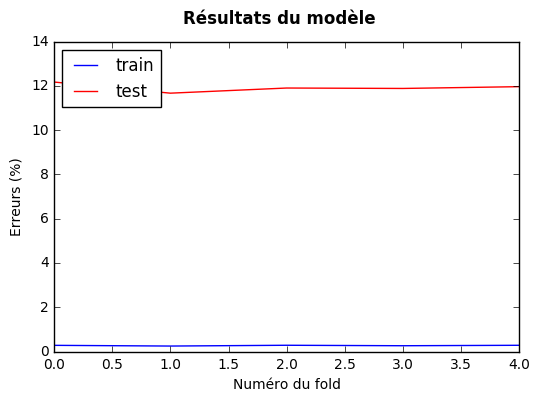

In [76]:
###################################################
# Random Forest
###################################################
clf = RandomForestClassifier()
result = compute_error_for_model(clf, X, y)
plot_result(result[0], result[1])

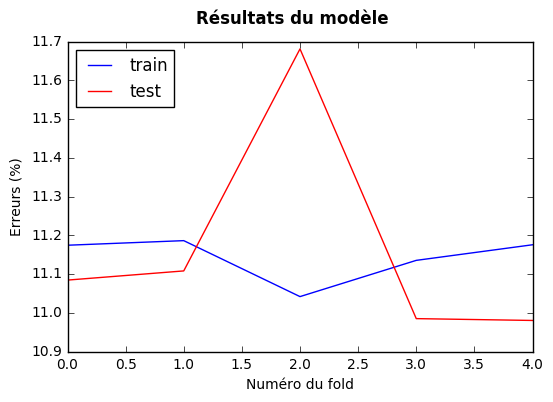

In [79]:
###################################################
# Naive Bayes
###################################################
clf = GaussianNB()
result = compute_error_for_model(clf, X, y)
plot_result(result[0], result[1])

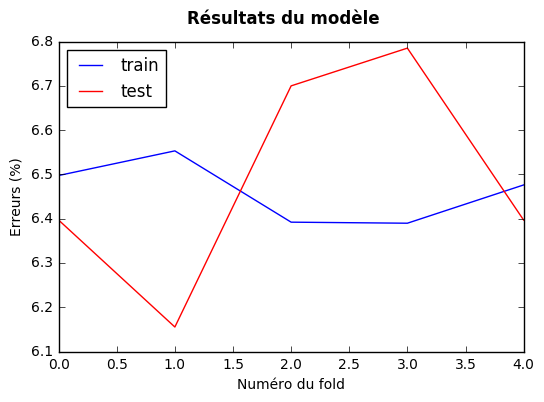

In [87]:
###################################################
# Analyse lineaire discriminante
##################################################
clf = LinearDiscriminantAnalysis()
result = compute_error_for_model(clf, X, y)
plot_result(result[0], result[1])

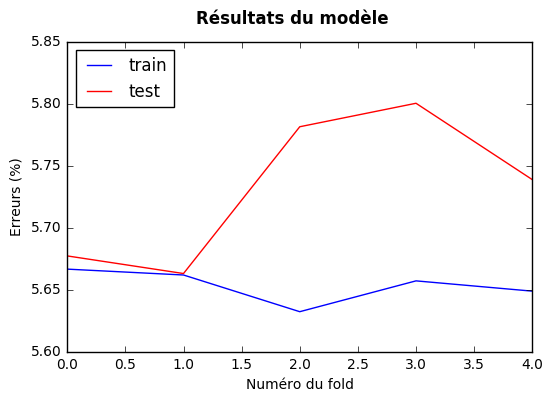

In [82]:
###################################################
# Analyse quadratique discriminante
##################################################
clf = QuadraticDiscriminantAnalysis()
result = compute_error_for_model(clf, X, y)
plot_result(result[0], result[1])

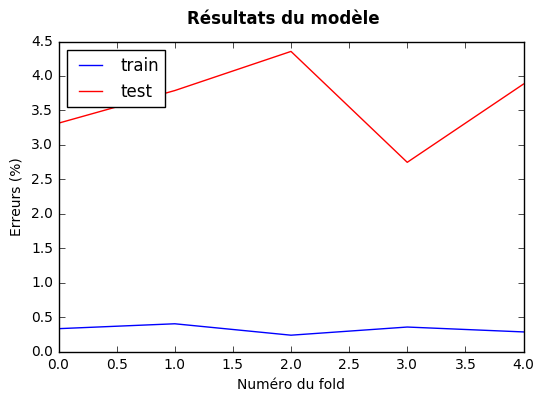

In [16]:
###################################################
# SVM
###################################################
clf = svm.SVC(C=10000, cache_size=2000)
result = compute_error_for_model(clf, X[0::20], y[0::20])
plot_result(result[0], result[1])

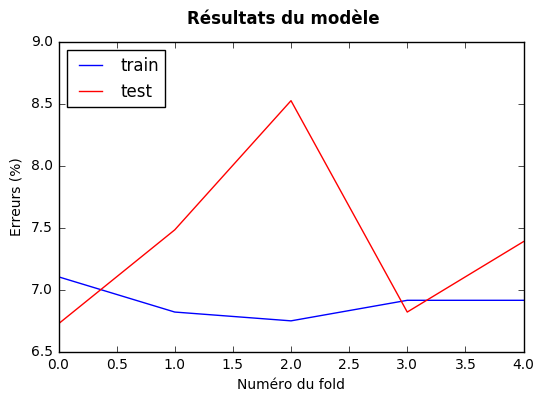

In [17]:
###################################################
# nuSVM
###################################################
clf = svm.NuSVC(cache_size=2000)
result = compute_error_for_model(clf, X[0::20], y[0::20])
plot_result(result[0], result[1])

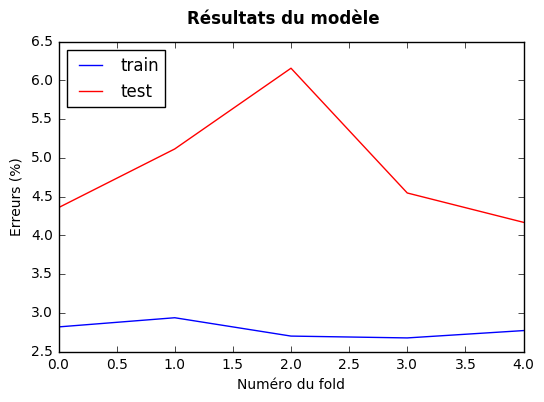

In [19]:
###################################################
# K plus proches voisins
###################################################
clf = KNeighborsClassifier(n_neighbors=5, algorithm="kd_tree")
result = compute_error_for_model(clf, X[0::20], y[0::20])
plot_result(result[0], result[1])

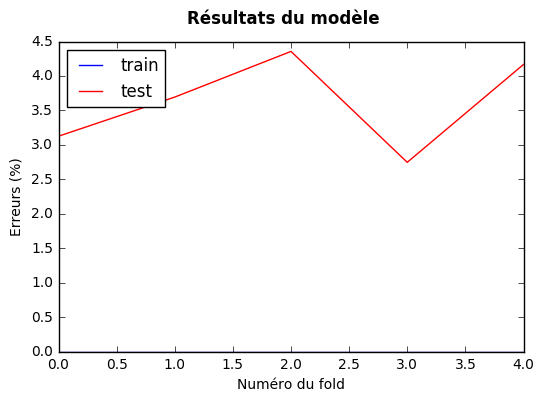

In [21]:
###################################################
# MLP
###################################################
clf = MLPClassifier()
result = compute_error_for_model(clf, X[0::20], y[0::20])
plot_result(result[0], result[1])

# Partie 3 : Optimisation des différents classifieurs déterminés à l'étape 2
## Mise en oeuvre de la régression logistique

### a) Pour la régularisation L2 déterminer le meilleur C

In [11]:
# Défition de la fonction qui va afficher pour chaque valeur
# d'une grille le resultat de la régression logistique
# Le résultat est calculé par validation croisé
def plot_reg_log_for_grid_C (grid, penalty, X, y):
    total_errors_train = np.zeros((len(grid), K))
    total_errors_test = np.zeros((len(grid), K))

    # Calcul des résultats pour chacune des valeurs de C via Cross Validation
    for i, elt in enumerate(grid):
        clf = LogisticRegression(penalty=penalty, C=elt)
        errors_train, errors_test = compute_error_for_model(clf, X, y)
        total_errors_train[i,:] = errors_train
        total_errors_test[i,:] = errors_test

    # Affichage sous forme de graphe des résultats
    for i in range(K):
        if i == 0:
            plt.semilogx(grid, total_errors_train[:,i], 'b', label="train")
            plt.semilogx(grid, total_errors_test[:,i], 'r', label="test")
        else:
            plt.semilogx(grid, total_errors_train[:,i], 'b')
            plt.semilogx(grid, total_errors_test[:,i], 'r')

    plt.suptitle("Apprentissage en fonction de la valeur de C", fontsize=12, fontweight='bold')
    plt.xlabel("Valeur de C")
    plt.ylabel("Erreurs (%)")
    plt.legend(loc="upper left")
    plt.show()

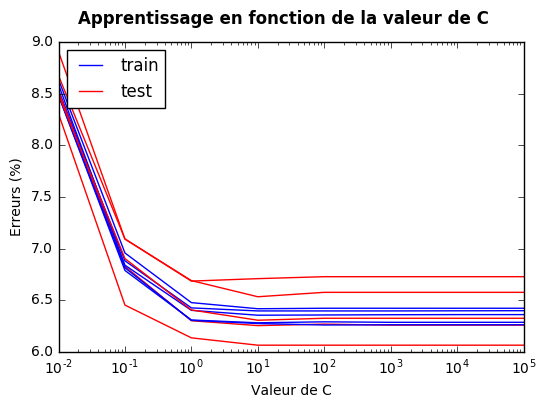

In [290]:
C = [0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]
plot_reg_log_for_grid_C(C, "l2", X, y)

<p>On constate donc que la bonne valeur de C est comprise entre 1 et 10</p>
<p>Affinons ce résultat en réévaluant de manière plus précise ce paramètre pour sur la plage [1, 10]</p>

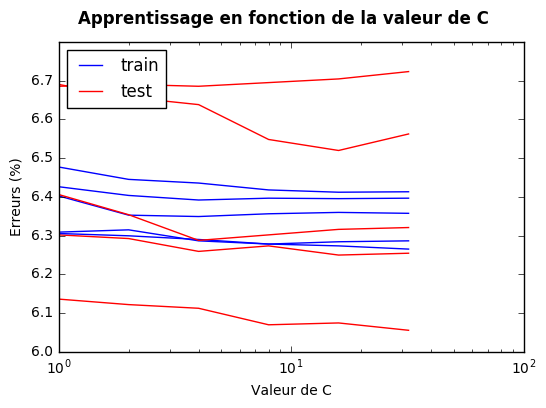

In [292]:
C = [1, 2, 4, 8, 16, 32]
plot_reg_log_for_grid_C(C, "l2", X, y)

Si l'on regarde sur le graphe il semblerait que C=4 donne en général les meilleurs résultats sur les données de trainings

### b) Pour la régularisation L1 déterminer le meilleur C, et voir quelle régularisation semble la plus appropriée


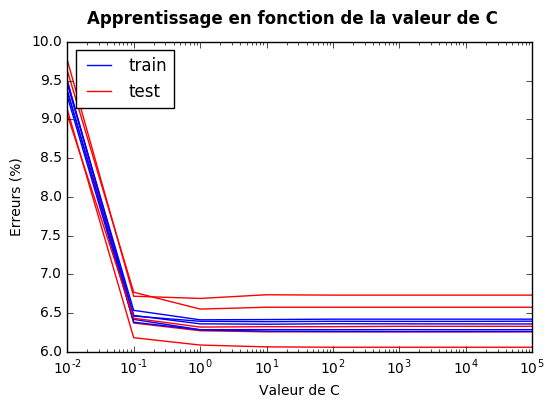

In [293]:
C = [0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]
plot_reg_log_for_grid_C(C, "l1", X, y)

<p>On constate donc que la bonne valeur de C est comprise entre 0.1 et 10</p>
<p>Affinons ce résultat en réévaluant de manière plus précise ce paramètre pour sur la plage [0.1, 10]</p>

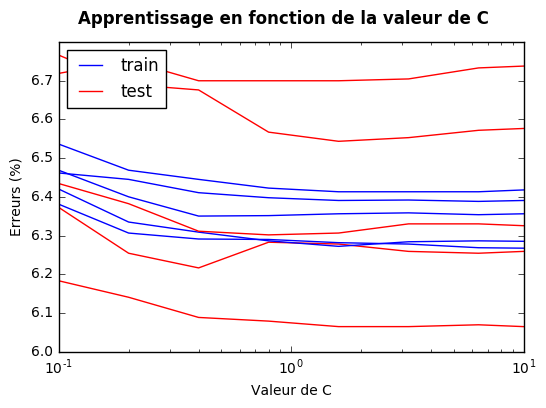

In [298]:
C = [0.1, 0.2, 0.4, 0.8, 1.6, 3.2, 6.4, 10]
plot_reg_log_for_grid_C(C, "l1", X, y)

<p>Le choix de 0.8 semble convenir quand on regarde le graphe</p>
<p>Ensuite entre les normes L1 et L2 au niveau des résultats ils semblent être à peu près équivalent il n'y a donc pas de raison d'en privilégier une plutôt qu'une autre</p>

### c) Choix du seuil de probabilité à partir duquel l'algorithme ne doit pas se prononcer

In [43]:
# Définition de la fonction qui ne prédira les valeurs 1
# et -1 qu'aux observations dont la probabilité d'étre égale
# à 1 ou -1 dépasse un certain seuil

def y_pred_from_y_proba(y_proba, threshold):
    y_pred = np.zeros(y_proba.shape[0])
    
    indice_un = np.where(y_proba[:,1] >= threshold)
    y_pred[indice_un[0]] = 1

    indice_moins_un = np.where(y_proba[:,0] >= threshold)
    y_pred[indice_moins_un[0]] = -1
    
    return y_pred

In [44]:
def compute_proba_for_model(model, X, y): 
    X_train_K, y_train_K, X_test_K, y_test_K = split_train_test_set(X, y)
    
    list_proba_train = [0] * K
    list_proba_test = [0] * K

    for i in range(K):
        model.fit(X_train_K[i], y_train_K[i])
        
        y_proba_train =  model.predict_proba(X_train_K[i])
        list_proba_train[i] = (y_proba_train, y_train_K[i])
        
        y_proba_test =  model.predict_proba(X_test_K[i])
        list_proba_test[i] = (y_proba_test, y_test_K[i])
    
    return list_proba_train, list_proba_test

In [25]:
thresold = [0.84, 0.86, 0.88, 0.9, 0.92, 0.94]

result = np.zeros((len(thresold), K))

clf_lg = LogisticRegression(penalty="l2", C=4)
list_proba_train, list_proba_test = compute_proba_for_model(clf_lg, X, y)

for i, y_proba_test in enumerate(list_proba_test) :
    for j, t in enumerate(thresold):
        y_pred = y_pred_from_y_proba(y_proba_test[0], t)
        result[j, i] = compute_pred_score(y_proba_test[1], y_pred)

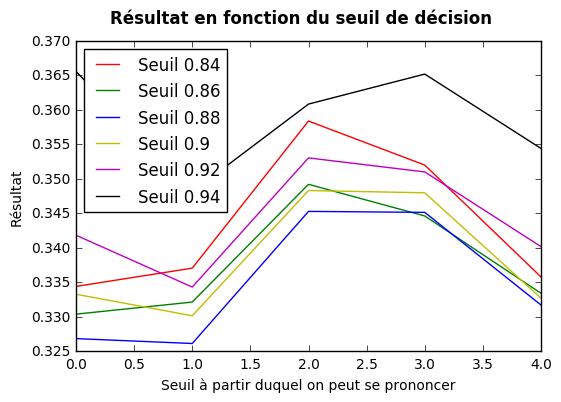

In [26]:
plt.rc('axes', prop_cycle=(cycler('color', ['r', 'g', 'b', 'y', 'm', 'k'])))
for i, t in enumerate(thresold):
    plt.plot(np.arange(K), result[i,:], label = "Seuil %s" % t)

plt.suptitle("Résultat en fonction du seuil de décision", fontsize=12, fontweight='bold')
plt.xlabel("Seuil à partir duquel on peut se prononcer")
plt.ylabel("Résultat")
plt.legend(loc="upper left")
plt.show()

Le seuil pour lequel le score est le meilleur est donc 0.88

### d) Conclusion
Pour la régression logistique nous allons donc utiliser :

- La penalisation l2 
- Une valeur de C égale à 4
- Un seuil en dessous duquel on ne se prononcera pas de 0.88

# Mise en oeuvre des K plus proches voisins

In [16]:
# Défition de la fonction qui va afficher pour chaque valeur
# d'une grille le resultat de la régression logistique
# Le résultat est calculé par validation croisé
def plot_knn_for_grid_C (grid, X, y):
    total_errors_train = np.zeros((len(grid), K))
    total_errors_test = np.zeros((len(grid), K))

    # Calcul des résultats pour chacune des valeurs de C via Cross Validation
    for i, elt in enumerate(grid):
        clf = KNeighborsClassifier(n_neighbors=elt, weights="distance", algorithm='kd_tree')
        errors_train, errors_test = compute_error_for_model(clf, X, y)
        total_errors_train[i,:] = errors_train
        total_errors_test[i,:] = errors_test

    # Affichage sous forme de graphe des résultats
    for i in range(K):
        if i == 0:
            plt.plot(grid, total_errors_train[:,i], 'b', label="train")
            plt.plot(grid, total_errors_test[:,i], 'r', label="test")
        else:
            plt.plot(grid, total_errors_train[:,i], 'b')
            plt.plot(grid, total_errors_test[:,i], 'r')

    plt.suptitle("Apprentissage en fonction de la valeur du nombre de voisins", fontsize=12, fontweight='bold')
    plt.xlim([grid[0], grid[len(grid)-1]])
    plt.xlabel("Valeur de C")
    plt.ylabel("Erreurs (%)")
    plt.legend(loc="upper left")
    plt.show()

### a) Utiliser un poids uniforme ou inversement proportionnel à la distance ?

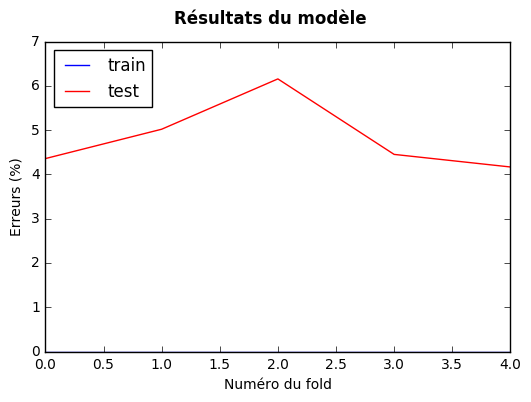

In [29]:
clf = KNeighborsClassifier(n_neighbors=5, weights="distance", algorithm='kd_tree')
model_knn = compute_error_for_model(clf, X[0::20], y[0::20])
plot_result(model_knn[0], model_knn[1])

In [ ]:
clf = KNeighborsClassifier(n_neighbors=5, weights="uniform", algorithm='kd_tree')
model_knn = compute_error_for_model(clf, X[0::20], y[0::20])
plot_result(model_knn[0], model_knn[1])

<p>Cela ne se voit pas sur le graphe, mais en comparant les valeurs numériques des résultats pour les données de test les valeurs sont soient égales soient légèrement meilleures qu'avec le cas des poids uniforme. Pour le training les résultats sont toujours égaux à 0.</p>
<p>Nous allons donc plutôt opter pour l'utilisation d'un poids inversement proportionnel aux distances</p>

### b) Détermination du nombre de voisins à utiliser

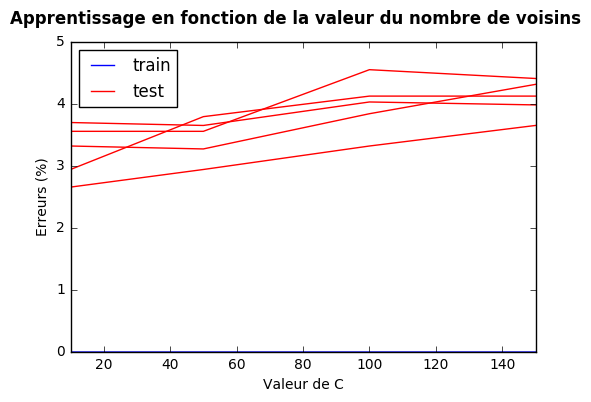

In [19]:
grid = [10, 50, 100, 150]
plot_knn_for_grid_C(grid=grid, X=X[0::10], y=y[0::10])

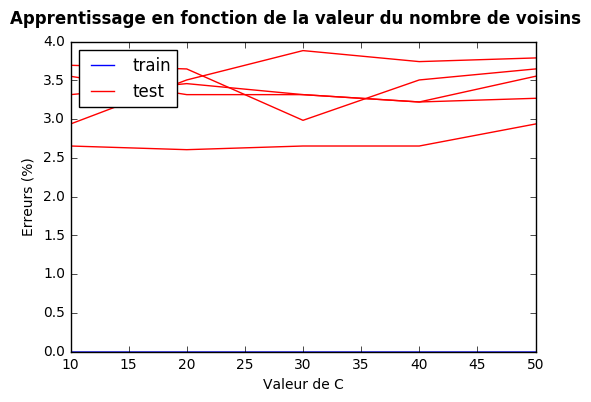

In [21]:
grid = [10, 20, 30, 40, 50]
plot_knn_for_grid_C(grid=grid, X=X[0::10], y=y[0::10])

La meilleure valeur semble donc être 30 plus proches voisins

### c) Choix du seuil à partir duquel l'algorithme ne doit pas se prononcer

L'algorithme des plus proches voisins attribut la valeur de 1 si la probabilité que l'observation corresponde à 1 soit de plus de 50%. Autour de cette zone des 50% la décision est donc tangeante. Le but de ce paragraphe est de voir quelle doit être la plage d'indécision pour obtenir le meilleur score. Cette fois nous parlons bien du cirtère de performance défini par la fonction "compute_pred_score"

In [35]:
# Définition de la fonction qui ne prédira les valeurs 1
# et -1 qu'aux observations dont la probabilité d'étre égale
# à 1 ou -1 dépasse un certain seuil

def y_pred_from_knn_y_proba(y_proba, threshold):
    y_pred = np.zeros(y_proba.shape[0])
    
    indice_un = np.where(y_proba[:,1] >= threshold)
    y_pred[indice_un[0]] = 1

    indice_moins_un = np.where(y_proba[:,0] >= threshold)
    y_pred[indice_moins_un[0]] = -1
    
    return y_pred

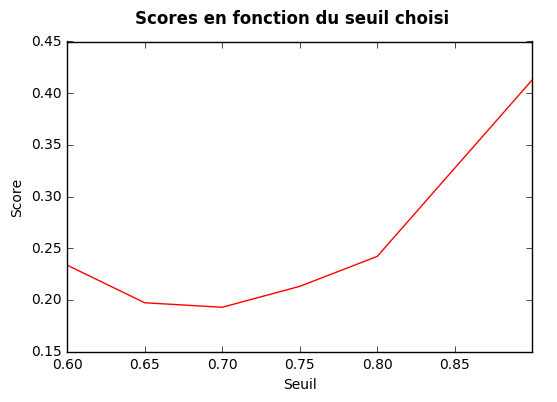

In [599]:
# Définition d'une grille de voisins et d'une
# grille de seuils
thresold = [0.6, 0.65, 0.7, 0.75, 0.8, 0.9]
result = np.zeros(len(thresold))

# Pour chacun des éléments de grilles calcul du résultat
# Nous calculons le résultat sur un set différent de celui du training
clf = KNeighborsClassifier(n_neighbors=30)
clf.fit(X[0::20], y[0::20])
y_proba = clf.predict_proba(X[1::20])
for i, t in enumerate(thresold):
    y_pred = y_pred_from_knn_y_proba(y_proba,t)
    result[i] = compute_pred_score(y[1::20], y_pred)

# Affichage sous forme de graphe des résultats
plt.plot(thresold, result)

plt.suptitle("Scores en fonction du seuil choisi", fontsize=12, fontweight='bold')
plt.xlabel("Seuil")
plt.xlim([0.6, 0.9])
plt.ylabel("Score")
plt.show()

On constate donc que le seuil le plus intéressant à conserver est celui de 70%. C'est-à-dire que si l'on est pas certain à plus de 70% du résultat il faut mieux laisser 0

### d) Conclusion

Dans l'étape précédente, sur le dernier graphe on constate qu'autour des 70% il vaut mieux utiliser un nombre de voisins important. Il semble il y avoir une faible différence de résultats entre 20 voisins et 30 voisins mais puisque les résultats sont très légèrement meilleur pour 30 voisins nous allons utiliser ce paramètre.

Pour les k plus proches voisins nous allons donc utiliser :

- Un poids qui tient compte des distances
- Un nombre de voisins égale à 30
- Un seuil à partir duquel on ne se prononce pas de 70%

# Mise en oeuvre des SVM
### a) Déterminer le meilleur C

In [601]:
# Défition de la fonction qui va afficher pour chaque valeur
# d'une grille le resultat de la régression logistique
# Le résultat est calculé par validation croisé
def plot_SVM_for_grid_C (grid, X, y):
    total_errors_train = np.zeros((len(grid), K))
    total_errors_test = np.zeros((len(grid), K))

    # Calcul des résultats pour chacune des valeurs de C via Cross Validation
    for i, elt in enumerate(grid):
        clf = svm.SVC(C=elt, cache_size=2000)
        errors_train, errors_test = compute_error_for_model(clf, X, y)
        total_errors_train[i,:] = errors_train
        total_errors_test[i,:] = errors_test

    # Affichage sous forme de graphe des résultats
    for i in range(K):
        if i == 0:
            plt.semilogx(grid, total_errors_train[:,i], 'b', label="train")
            plt.semilogx(grid, total_errors_test[:,i], 'r', label="test")
        else:
            plt.semilogx(grid, total_errors_train[:,i], 'b')
            plt.semilogx(grid, total_errors_test[:,i], 'r')

    plt.suptitle("Apprentissage en fonction de la valeur de C", fontsize=12, fontweight='bold')
    plt.xlabel("Valeur de C")
    plt.ylabel("Erreurs (%)")
    plt.legend(loc="upper left")
    plt.show()

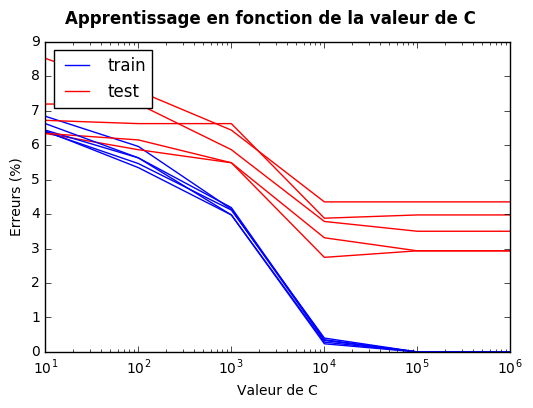

In [416]:
grid = [10, 100, 1000, 10000, 100000, 1000000]
plot_SVM_for_grid_C(grid, X[0::20], y[0::20])

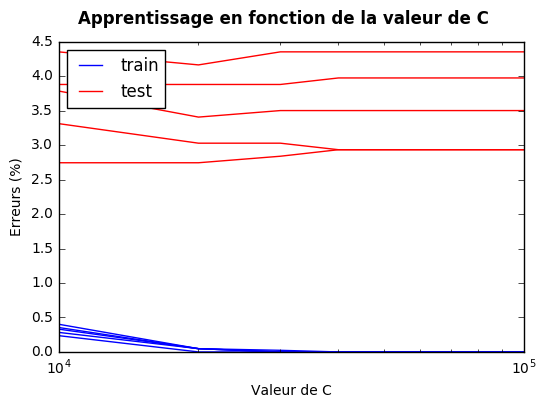

In [604]:
grid = [10000, 20000, 30000, 40000, 60000, 80000, 100000]
plot_SVM_for_grid_C(grid, X[0::20], y[0::20])

<p> La meilleure valeur pour C semble donc être 20 000</p>

### c) Choix du meilleur gamma

In [24]:
# Défition de la fonction qui va afficher pour chaque valeur
# d'une grille le resultat de la régression logistique
# Le résultat est calculé par validation croisé
def plot_SVM_for_grid_gamma (grid, X, y):
    total_errors_train = np.zeros((len(grid), K))
    total_errors_test = np.zeros((len(grid), K))

    # Calcul des résultats pour chacune des valeurs de gamma via Cross Validation
    for i, elt in enumerate(grid):
        clf = svm.SVC(gamma=elt, cache_size=2000, C=20000)
        errors_train, errors_test = compute_error_for_model(clf, X, y)
        total_errors_train[i,:] = errors_train
        total_errors_test[i,:] = errors_test

    # Affichage sous forme de graphe des résultats
    for i in range(K):
        if i == 0:
            plt.plot(grid, total_errors_train[:,i], 'b', label="train")
            plt.plot(grid, total_errors_test[:,i], 'r', label="test")
        else:
            plt.plot(grid, total_errors_train[:,i], 'b')
            plt.plot(grid, total_errors_test[:,i], 'r')

    plt.suptitle("Apprentissage en fonction de la valeur de gamma", fontsize=12, fontweight='bold')
    plt.xlabel("Valeur de gamma")
    plt.ylabel("Erreurs (%)")
    plt.legend(loc="upper left")
    plt.show()

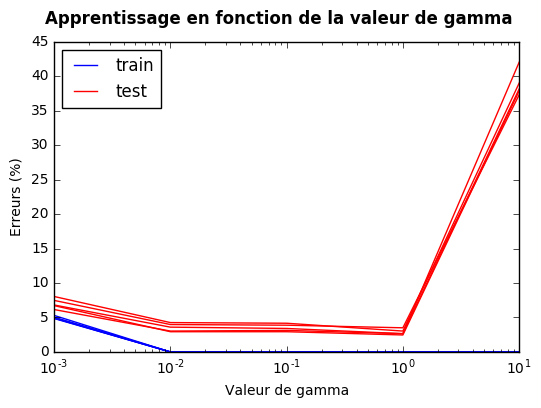

In [22]:
grid = [1e-3, 1e-2, 1e-1, 1, 10]
plot_SVM_for_grid_gamma(grid, X[0::20], y[0::20])

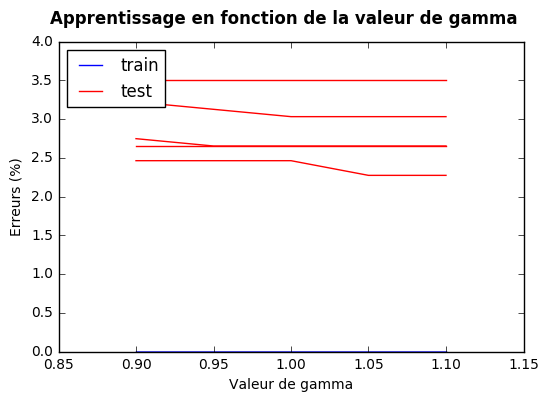

In [25]:
grid = [9e-1, 9.5e-1, 1, 1.05, 1.1]
plot_SVM_for_grid_gamma(grid, X[0::20], y[0::20])

Pour valeur de gamma nous allons donc choisir 1.05

### c) Choix du seuil de probabilité à partir duquel l'algorithme ne doit pas se prononcer

In [8]:
# Définition de la fonction qui ne prédira les valeurs 1
# et -1 qu'aux observations dont la probabilité d'étre égale
# à 1 ou -1 dépasse un certain seuil

def y_pred_from_svm_distance(distance, threshold):
    y_pred = np.zeros(len(distance))
    
    indice_un = np.where(distance >= threshold)
    y_pred[indice_un[0]] = 1

    indice_moins_un = np.where(distance <= -threshold)
    y_pred[indice_moins_un[0]] = -1
    
    return y_pred

In [9]:
def compute_distance_for_model(model, X, y): 
    X_train_K, y_train_K, X_test_K, y_test_K = split_train_test_set(X, y)
    
    list_distance_train = [0] * K
    list_distance_test = [0] * K

    for i in range(K):
        model.fit(X_train_K[i], y_train_K[i])
        
        y_distance_train =  model.decision_function(X_train_K[i])
        list_distance_train[i] = (y_distance_train, y_train_K[i])
        
        y_distance_test =  model.decision_function(X_test_K[i])
        list_distance_test[i] = (y_distance_test, y_test_K[i])
    
    return list_distance_train, list_distance_test

In [16]:
distance = [0.4, 0.5, 0.6, 0.7]

result = np.zeros((len(distance), K))

clf_svm = svm.SVC(C=20000, cache_size=2000)

list_distance_train, list_distance_test = compute_distance_for_model(clf_svm, X[::10], y[::10])

for i, y_distance_test in enumerate(list_distance_test) :
    for j, d in enumerate(distance):
        y_pred = y_pred_from_svm_distance(y_distance_test[0], d)
        result[j, i] = compute_pred_score(y_distance_test[1], y_pred)

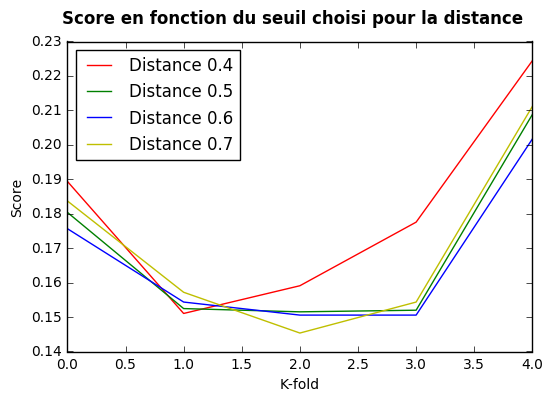

In [17]:
plt.rc('axes', prop_cycle=(cycler('color', ['r', 'g', 'b', 'y', 'm', 'k'])))
for i, d in enumerate(distance):
    plt.plot(np.arange(K), result[i,:], label = "Distance %s" % d)

plt.suptitle("Score en fonction du seuil choisi pour la distance", fontsize=12, fontweight='bold')
plt.xlabel("K-fold")
plt.ylabel("Score")
plt.legend(loc="upper left")
plt.show()

### c) Conclusion

Pour le SVM nous allons donc utiliser :

- Une valeur de C égale à 20000
- Une valeur de gamma égale 1.5
- Une distance de 0.6, distance en dessous de laquelle on ne se prononce pas

# Mise en oeuvre nu SVM
### a) Choix du meilleur noyau

In [26]:
# Défition de la fonction qui va afficher pour chaque valeur
# d'une grille le resultat de la régression logistique
# Le résultat est calculé par validation croisé
def plot_SVM_for_kernel (X, y):
    total_errors_train = np.zeros((5, K))
    total_errors_test = np.zeros((5, K))

    # Calcul Noyau lineaire
    clf_linear = svm.NuSVC(kernel="linear", cache_size=2000)
    errors_train, errors_test = compute_error_for_model(clf_linear, X, y)
    total_errors_train[0,:] = errors_train
    total_errors_test[0,:] = errors_test
    print("Calcul pour le noyau linéaire terminé")

    # Calcul Noyau plynomial
    clf_poly = svm.NuSVC(kernel="poly", cache_size=2000)
    errors_train, errors_test = compute_error_for_model(clf_poly, X, y)
    total_errors_train[1,:] = errors_train
    total_errors_test[1,:] = errors_test
    print("Calcul pour le noyau linéaire polynomial")
    
    # Calcul Noyau RBF
    clf_rbf = svm.NuSVC(kernel="rbf", cache_size=2000)
    errors_train, errors_test = compute_error_for_model(clf_rbf, X, y)
    total_errors_train[2,:] = errors_train
    total_errors_test[2,:] = errors_test
    print("Calcul pour le noyau RBF terminé")
    
    # Calcul Noyau sigmoid
    clf_sig = svm.NuSVC(kernel="sigmoid", cache_size=2000)
    errors_train, errors_test = compute_error_for_model(clf_sig, X, y)
    total_errors_train[3,:] = errors_train
    total_errors_test[3,:] = errors_test
    print("Calcul pour le noyau sigmoid terminé")
    
    # Affichage sous forme de graphe des résultats
    for i in range(5):
        if i == 0:
            plt.plot(grid, total_errors_train[:,i], 'b', label="train")
            plt.plot(grid, total_errors_test[:,i], 'r', label="test")
        else:
            plt.plot(grid, total_errors_train[:,i], 'b')
            plt.plot(grid, total_errors_test[:,i], 'r')

    plt.suptitle("Apprentissage en fonction du type de noyau", fontsize=12, fontweight='bold')
    plt.xlabel("Valeur de nu")
    plt.ylabel("Erreurs (%)")
    plt.legend(loc="upper left")
    plt.show()

Calcul pour le noyau linéaire terminé
Calcul pour le noyau linéaire polynomial
Calcul pour le noyau RBF terminé
Calcul pour le noyau sigmoid terminé


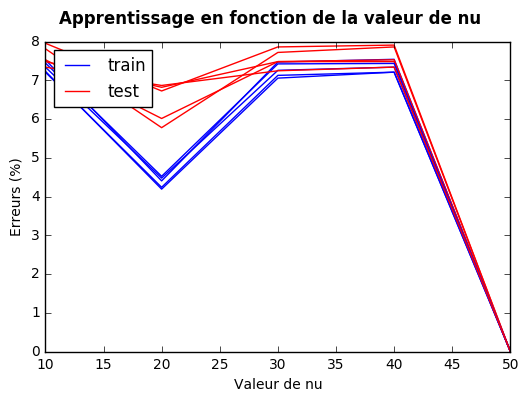

In [28]:
plot_SVM_for_kernel(X[0::10], y[0::10])

On constate donc que le noyau polynomial réalise les meilleures performances

### a) Choix du meilleur nu

In [66]:
# Défition de la fonction qui va afficher pour chaque valeur
# d'une grille le resultat de la régression logistique
# Le résultat est calculé par validation croisé
def plot_SVM_for_grid_nu (grid, X, y):
    total_errors_train = np.zeros((len(grid), K))
    total_errors_test = np.zeros((len(grid), K))

    # Calcul des résultats pour chacune des valeurs de C via Cross Validation
    for i, elt in enumerate(grid):
        clf = svm.NuSVC(nu=elt, cache_size=2000)
        errors_train, errors_test = compute_error_for_model(clf, X, y)
        total_errors_train[i,:] = errors_train
        total_errors_test[i,:] = errors_test

    # Affichage sous forme de graphe des résultats
    for i in range(K):
        if i == 0:
            plt.plot(grid, total_errors_train[:,i], 'b', label="train")
            plt.plot(grid, total_errors_test[:,i], 'r', label="test")
        else:
            plt.plot(grid, total_errors_train[:,i], 'b')
            plt.plot(grid, total_errors_test[:,i], 'r')

    plt.suptitle("Apprentissage en fonction de la valeur de nu", fontsize=12, fontweight='bold')
    plt.xlabel("Valeur de nu")
    plt.ylabel("Erreurs (%)")
    plt.legend(loc="upper left")
    plt.show()

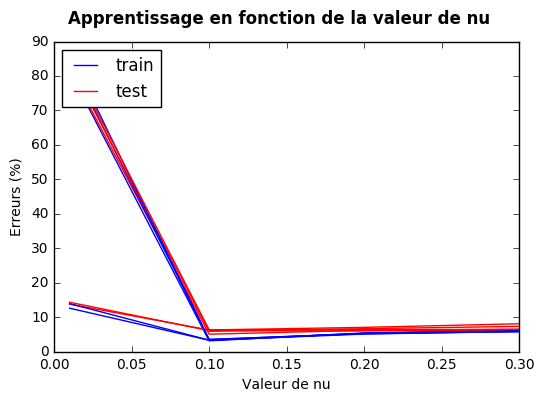

In [71]:
grid = [0.01, 0.1, 0.2, 0.3]
plot_SVM_for_grid_nu(grid, X[0::20], y[0::20])

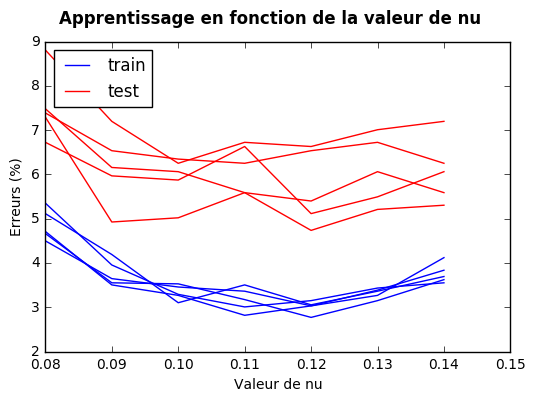

In [74]:
grid = [0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14]
plot_SVM_for_grid_nu(grid, X[0::20], y[0::20])

### c) Choix du meilleur gamma

In [75]:
# Défition de la fonction qui va afficher pour chaque valeur
# d'une grille le resultat de la régression logistique
# Le résultat est calculé par validation croisé
def plot_SVM_for_grid_gamma (grid, X, y):
    total_errors_train = np.zeros((len(grid), K))
    total_errors_test = np.zeros((len(grid), K))

    # Calcul des résultats pour chacune des valeurs de C via Cross Validation
    for i, elt in enumerate(grid):
        clf = svm.NuSVC(gamma=elt, cache_size=2000, nu=0.12)
        errors_train, errors_test = compute_error_for_model(clf, X, y)
        total_errors_train[i,:] = errors_train
        total_errors_test[i,:] = errors_test

    # Affichage sous forme de graphe des résultats
    for i in range(K):
        if i == 0:
            plt.semilogx(grid, total_errors_train[:,i], 'b', label="train")
            plt.semilogx(grid, total_errors_test[:,i], 'r', label="test")
        else:
            plt.semilogx(grid, total_errors_train[:,i], 'b')
            plt.semilogx(grid, total_errors_test[:,i], 'r')

    plt.suptitle("Apprentissage en fonction de la valeur de gamma", fontsize=12, fontweight='bold')
    plt.xlabel("Valeur de gamma")
    plt.ylabel("Erreurs (%)")
    plt.legend(loc="upper left")
    plt.show()

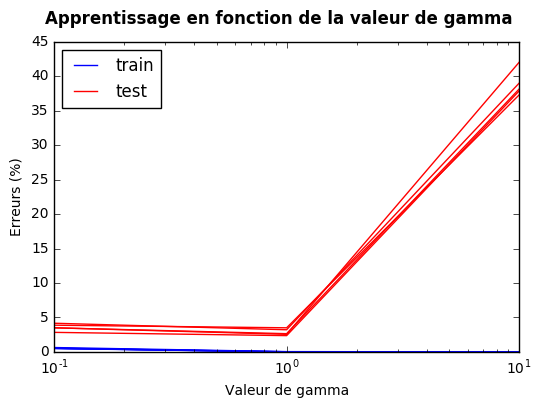

In [78]:
grid = [1e-1, 1, 10]
plot_SVM_for_grid_gamma(grid, X[0::20], y[0::20])

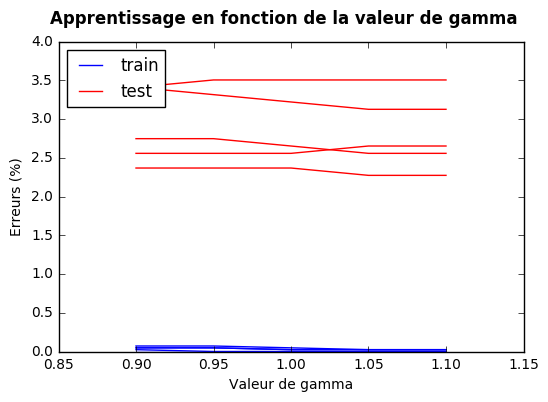

In [80]:
grid = [0.9, 0.95, 1, 1.05, 1.1]
plot_SVM_for_grid_gamma(grid, X[0::20], y[0::20])

Pour valeur de gamma nous allons donc choisir 1.05

### d) Choix du seuil de probabilité à partir duquel l'algorithme ne doit pas se prononcer

In [83]:
clf_svmnu = svm.NuSVC(nu=0.12, gamma=1.05, cache_size=2000)
list_distance_train, list_distance_test = compute_distance_for_model(clf_svmnu, X[0::20], y[0::20])

distance = [0.1, 0.5, 1, 2, 3, 5, 10]

result = np.zeros((len(distance), K))

#clf_svmnu = svm.NuSVC(nu=0.1, cache_size=2000)
for i, y_distance_test in enumerate(list_distance_test) :
    for j, d in enumerate(distance):
        y_pred = y_pred_from_svm_distance(y_distance_test[0], d)
        result[j, i] = compute_pred_score(y_distance_test[1], y_pred)

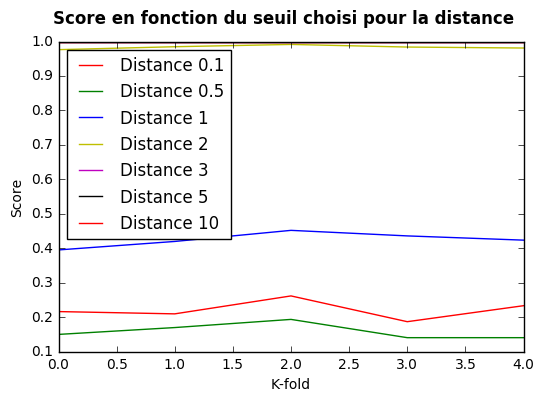

In [84]:
plt.rc('axes', prop_cycle=(cycler('color', ['r', 'g', 'b', 'y', 'm', 'k'])))
for i, d in enumerate(distance):
    plt.plot(np.arange(K), result[i,:], label = "Distance %s" % d)

plt.suptitle("Score en fonction du seuil choisi pour la distance", fontsize=12, fontweight='bold')
plt.xlabel("K-fold")
plt.ylabel("Score")
plt.legend(loc="upper left")
plt.show()

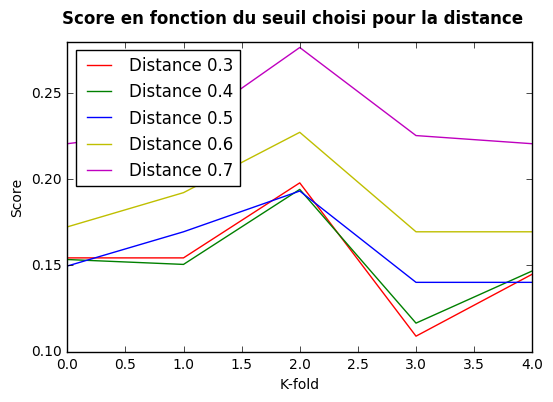

In [87]:
distance = [0.3, 0.4, 0.5, 0.6, 0.7]
result = np.zeros((len(distance), K))

for i, y_distance_test in enumerate(list_distance_test) :
    for j, d in enumerate(distance):
        y_pred = y_pred_from_svm_distance(y_distance_test[0], d)
        result[j, i] = compute_pred_score(y_distance_test[1], y_pred)
        
plt.rc('axes', prop_cycle=(cycler('color', ['r', 'g', 'b', 'y', 'm', 'k'])))
for i, d in enumerate(distance):
    plt.plot(np.arange(K), result[i,:], label = "Distance %s" % d)

plt.suptitle("Score en fonction du seuil choisi pour la distance", fontsize=12, fontweight='bold')
plt.xlabel("K-fold")
plt.ylabel("Score")
plt.legend(loc="upper left")
plt.show()

Nous allons donc utiliser 0.4 comme seuil à partir duquel on ne prend pas de décision

### e) Conclusion

Pour les nuSVR nous allons donc utiliser :

- Une valeur de nu de 0.12
- Une valeur de gamma de 1.05 
- Un distance en dessous de laquelle on ne se prononce pas de 0.4

# Mise en oeuvre QDA
### a) Déterminer le meilleur paramètre

In [358]:
# Défition de la fonction qui va afficher pour chaque valeur
# d'une grille le resultat de la régression logistique
# Le résultat est calculé par validation croisé
def plot_qda_for_grid_param (grid, X, y):
    total_errors_train = np.zeros((len(grid), K))
    total_errors_test = np.zeros((len(grid), K))

    # Calcul des résultats pour chacune des valeurs de C via Cross Validation
    for i, elt in enumerate(grid):
        clf = QuadraticDiscriminantAnalysis(reg_param=elt)
        errors_train, errors_test = compute_error_for_model(clf, X, y)
        total_errors_train[i,:] = errors_train
        total_errors_test[i,:] = errors_test

    # Affichage sous forme de graphe des résultats
    for i in range(K):
        if i == 0:
            plt.semilogx(grid, total_errors_train[:,i], 'b', label="train")
            plt.semilogx(grid, total_errors_test[:,i], 'r', label="test")
        else:
            plt.semilogx(grid, total_errors_train[:,i], 'b')
            plt.semilogx(grid, total_errors_test[:,i], 'r')

    plt.suptitle("Apprentissage en fonction de la valeur de C", fontsize=12, fontweight='bold')
    plt.xlabel("Valeur de C")
    plt.ylabel("Erreurs (%)")
    plt.legend(loc="upper left")
    plt.show()

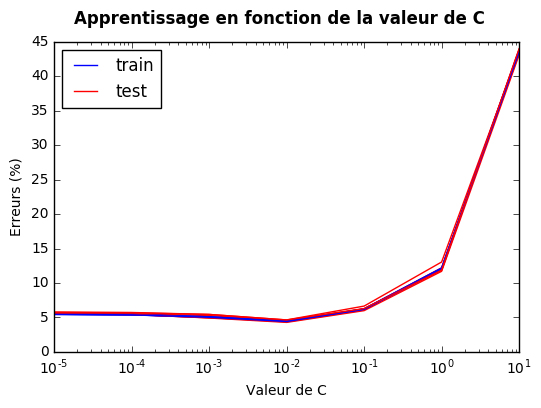

In [361]:
grid = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]
plot_qda_for_grid_param(grid, X[0::2], y[0::2])

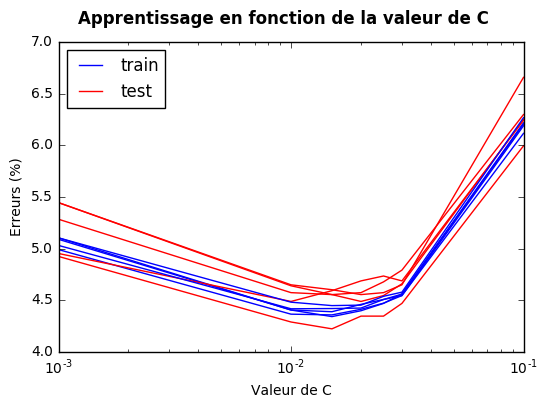

In [367]:
grid = [1e-3, 10e-3, 15e-3, 20e-3, 25e-3, 30e-3, 100e-3]
plot_qda_for_grid_param(grid, X[0::2], y[0::2])

La meilleure valeur du paramètre semble donc être 15e-3

### b) Choix du seuil de probabilité à partir duquel l'algorithme ne doit pas se prononcer

In [371]:
clf_qda = QuadraticDiscriminantAnalysis(reg_param=15e-3)
list_proba_train, list_proba_test = compute_proba_for_model(clf_qda, X, y)

In [376]:
thresold = [0.7, 0.75, 0.8, 0.85, 0.9]

for i, y_proba_test in enumerate(list_proba_test) :
    for j, t in enumerate(thresold):
        y_pred = y_pred_from_knn_y_proba(y_proba_test[0], t)
        result[j, i] = compute_pred_score(y_proba_test[1], y_pred)

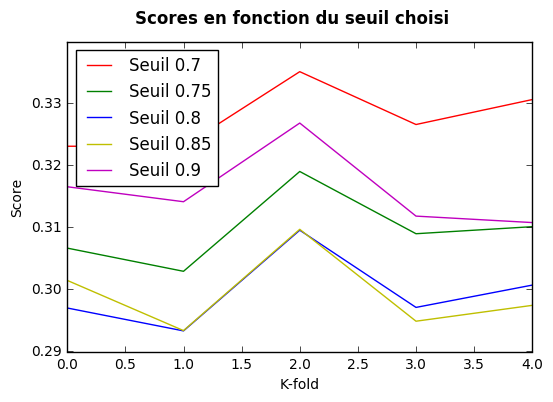

In [378]:
plt.rc('axes', prop_cycle=(cycler('color', ['r', 'g', 'b', 'y', 'm', 'k'])))
for i, t in enumerate(thresold):
    plt.plot(np.arange(K), result[i,:], label = "Seuil %s" % t)

plt.suptitle("Scores en fonction du seuil choisi", fontsize=12, fontweight='bold')
plt.xlabel("K-fold")
plt.ylabel("Score")
plt.legend(loc="upper left")
plt.show()

Le meilleur score est obtenu pour un seuil entre 0.8 et 0.85

Pour qda nous allons donc utiliser :

- Un paramètre de régularisation de 15e-3
- Un seuil en dessous duquel on ne se prononce pas de 0.8

# Mise en oeuvre MLP
### a) Déterminer le meilleur paramètre pour le nombre de couches

In [149]:
# Défition de la fonction qui va afficher pour chaque valeur
# d'une grille le resultat de la régression logistique
# Le résultat est calculé par validation croisé
def plot_mlp_for_grid_param (grid, X, y):
    total_errors_train = np.zeros((len(grid), K))
    total_errors_test = np.zeros((len(grid), K))

    # Calcul des résultats pour chacune des valeurs de C via Cross Validation
    for i, elt in enumerate(grid):
        clf = MLPClassifier(hidden_layer_sizes=elt)
        errors_train, errors_test = compute_error_for_model(clf, X, y)
        total_errors_train[i,:] = errors_train
        total_errors_test[i,:] = errors_test

    # Affichage sous forme de graphe des résultats
    for i in range(K):
        if i == 0:
            plt.plot(grid, total_errors_train[:,i], 'b', label="train")
            plt.plot(grid, total_errors_test[:,i], 'r', label="test")
        else:
            plt.plot(grid, total_errors_train[:,i], 'b')
            plt.plot(grid, total_errors_test[:,i], 'r')

    plt.suptitle("Apprentissage en fonction de la valeur du nombre de couches", fontsize=12, fontweight='bold')
    plt.xlabel("Valeur du nombre de couches")
    plt.xlim([grid[0], grid[-1]])
    plt.ylabel("Erreurs (%)")
    plt.legend(loc="upper left")
    plt.show()

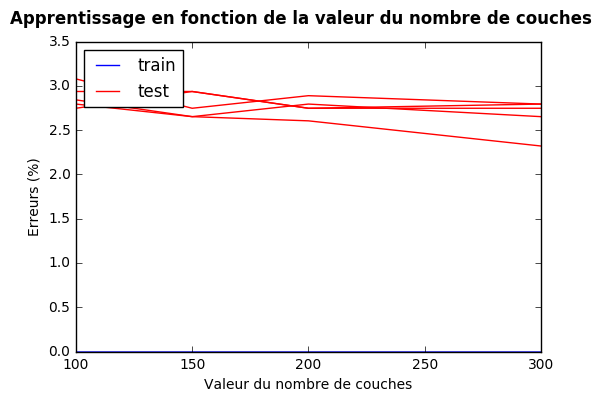

In [161]:
grid = [100, 150, 200, 300]
plot_mlp_for_grid_param(grid, X[0::10], y[0::10])

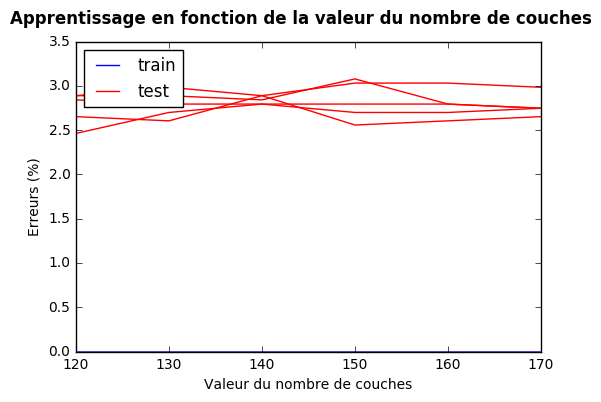

In [162]:
grid = [120, 130, 140, 150, 160, 170]
plot_mlp_for_grid_param(grid, X[0::10], y[0::10])

La meilleure valeur du paramètre semble donc être 140

### b) Déterminer la meilleure valeur pour le paramètre alpha

In [167]:
# Défition de la fonction qui va afficher pour chaque valeur
# d'une grille le resultat de la régression logistique
# Le résultat est calculé par validation croisé
def plot_mlp_for_grid_param_alpha(grid, X, y):
    total_errors_train = np.zeros((len(grid), K))
    total_errors_test = np.zeros((len(grid), K))

    # Calcul des résultats pour chacune des valeurs de C via Cross Validation
    for i, elt in enumerate(grid):
        clf = MLPClassifier(alpha=elt, hidden_layer_sizes=140)
        errors_train, errors_test = compute_error_for_model(clf, X, y)
        total_errors_train[i,:] = errors_train
        total_errors_test[i,:] = errors_test

    # Affichage sous forme de graphe des résultats
    for i in range(K):
        if i == 0:
            plt.plot(grid, total_errors_train[:,i], 'b', label="train")
            plt.plot(grid, total_errors_test[:,i], 'r', label="test")
        else:
            plt.plot(grid, total_errors_train[:,i], 'b')
            plt.plot(grid, total_errors_test[:,i], 'r')

    plt.suptitle("Apprentissage en fonction de la valeur de alpha", fontsize=12, fontweight='bold')
    plt.xlabel("Valeur de alpha")
    plt.xlim([grid[0], grid[-1]])
    plt.ylabel("Erreurs (%)")
    plt.legend(loc="upper left")
    plt.show()

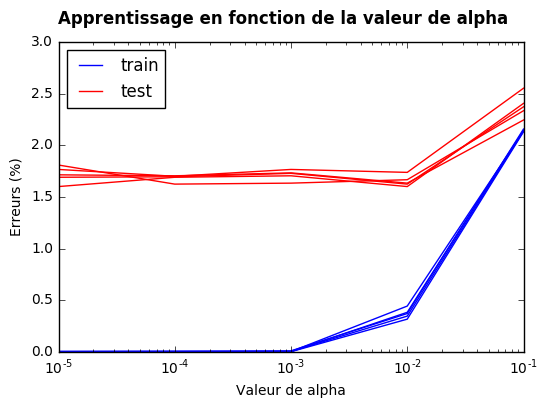

In [164]:
grid = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
plot_mlp_for_grid_param_alpha(grid, X, y)

La meilleur solution est donc pour alpha égal à 1e-2

### c) Choix du seuil de probabilité à partir duquel l'algorithme ne doit pas se prononcer

In [213]:
clf_mlp = MLPClassifier(hidden_layer_sizes=140, alpha=1e-2)
list_proba_train, list_proba_test = compute_proba_for_model(clf_mlp, X, y)

In [216]:
thresold = [0.85, 0.9, 0.95, 0.99]
result = np.zeros((len(thresold), K))

for i, y_proba_test in enumerate(list_proba_test) :
    for j, t in enumerate(thresold):
        y_pred = y_pred_from_y_proba(y_proba_test[0], t)
        result[j, i] = compute_pred_score(y_proba_test[1], y_pred)

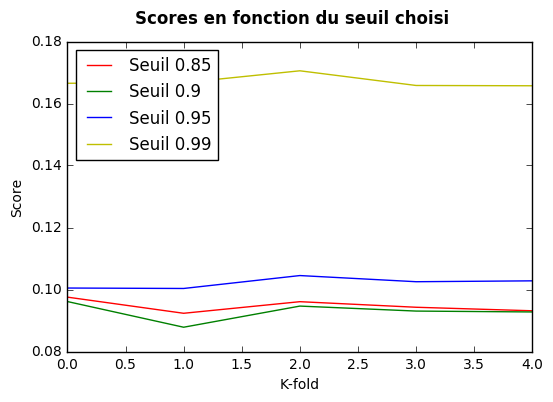

In [217]:
plt.rc('axes', prop_cycle=(cycler('color', ['r', 'g', 'b', 'y', 'm', 'k'])))
for i, t in enumerate(thresold):
    plt.plot(np.arange(K), result[i,:], label = "Seuil %s" % t)

plt.suptitle("Scores en fonction du seuil choisi", fontsize=12, fontweight='bold')
plt.xlabel("K-fold")
plt.ylabel("Score")
plt.legend(loc="upper left")
plt.show()

Le meilleur score est obtenu pour un seuil de 0.9

### d) Conclusion
Pour les réseaux de neurones nous allons donc utiliser :

- Un nombre de couche de 140
- Un paramètre alpha de 1e-2
- Un seuil en dessous duquel on ne se prononce pas de 90%

# Partie 4 : Analyse des résultats des différents classifieurs sur le test

In [33]:
# Fonction d'analyse des résultats
def analyse_real_result(result, y_pred):
    nb_zeros = len(np.where(y_pred == 0)[0])
    nb_errors = int((result * X_test.shape[0] - nb_zeros)/10)
    print ("Nombre de valeurs prédites à zéro : {}".format(nb_zeros))
    print("Nombre d'erreurs commises : {}".format(nb_errors))

### Classifieur régression logistique

In [447]:
clf_lg = LogisticRegression(penalty="l2", C=4)
clf_lg.fit(X, y)

LogisticRegression(C=4, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [448]:
y_proba_lg = clf_lg.predict_proba(X_test)

In [94]:
y_pred_lg = y_pred_from_y_proba(y_proba_lg, 0.88)
np.savetxt('y_pred_lg.txt', y_pred_lg, fmt='%d')

In [95]:
# cas seuil = 0.88
analyse_real_result(0.656544256121, y_pred_lg)

Nombre de valeurs prédites à zéro : 2749
Nombre d'erreurs commises : 282


### Classifieur KNN

In [235]:
clf_knn = KNeighborsClassifier(n_neighbors=30, weights="distance", algorithm='kd_tree')
clf_knn.fit(X, y)

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=30, p=2,
           weights='distance')

In [236]:
y_proba_knn = clf_knn.predict_proba(X_test)

In [38]:
y_pred_knn = y_pred_from_knn_y_proba(y_proba_knn, 0.70)
np.savetxt('y_pred_knn.txt', y_pred_knn, fmt='%d')

En soumettant ce résultat sur le site on obtient un score de 0.168785310734.
Analysons ce résultat :

In [39]:
analyse_real_result(0.191384180791, y_pred_knn)

Nombre de valeurs prédites à zéro : 655
Nombre d'erreurs commises : 97


### Classifieur SVC

In [237]:
clf_svm = svm.SVC(C=20000, gamma=1.05, cache_size=2000)
clf_svm.fit(X, y)

SVC(C=20000, cache_size=2000, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=1.05, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [238]:
distance_svm = clf_svm.decision_function(X_test)

In [31]:
y_pred_svm = y_pred_from_svm_distance(distance_svm, 0.6)
np.savetxt('y_pred_svm.txt', y_pred_svm, fmt='%d')

In [34]:
# Pour la distance 1
analyse_real_result(0.179378531073, y_pred_svm)

Nombre de valeurs prédites à zéro : 737
Nombre d'erreurs commises : 78


### Classifieur nu SVC

In [239]:
clf_svmnu = svm.NuSVC(nu=0.12, gamma=1.05, cache_size=2000)
clf_svmnu.fit(X, y)

NuSVC(cache_size=2000, class_weight=None, coef0=0.0,
   decision_function_shape=None, degree=3, gamma=1.05, kernel='rbf',
   max_iter=-1, nu=0.12, probability=False, random_state=None,
   shrinking=True, tol=0.001, verbose=False)

In [240]:
distance_svmnu = clf_svmnu.decision_function(X_test)

In [395]:
y_pred_svmnu = y_pred_from_svm_distance(distance_svmnu, 0.4)
np.savetxt('y_pred_svmnu.txt', y_pred_svmnu, fmt='%d')

In [389]:
# Pour la distance 1
analyse_real_result(0.153248587571, y_pred_svmnu)

Nombre de valeurs prédites à zéro : 427
Nombre d'erreurs commises : 87


### Classifieur QDA

In [40]:
clf_qda = QuadraticDiscriminantAnalysis(reg_param=15e-3)

clf_qda.fit(X, y)

QuadraticDiscriminantAnalysis(priors=None, reg_param=0.015,
               store_covariances=False, tol=0.0001)

In [41]:
y_proba_qda = clf_qda.predict_proba(X_test)

In [45]:
y_pred_qda = y_pred_from_y_proba(y_proba_qda, 0.80)
np.savetxt('y_pred_qda.txt', y_pred_qda, fmt='%d')

In [386]:
# Pour le seuil = 0.8
analyse_real_result(0.231873822976, y_pred_qda)

Nombre de valeurs prédites à zéro : 1332
Nombre d'erreurs commises : 63


### Classifieur réseaux de neurones

In [241]:
clf_mlp = MLPClassifier(hidden_layer_sizes=140, alpha=1e-2)
clf_mlp.fit(X, y)

MLPClassifier(activation='relu', alpha=0.01, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=140, learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [242]:
y_proba_mlp = clf_mlp.predict_proba(X_test)

In [218]:
y_pred_mlp = y_pred_from_y_proba(y_proba_mlp, 0.9)
np.savetxt('y_pred_mlp.txt', y_pred_mlp, fmt='%d')

In [219]:
# Pour le seuil = 0.90
analyse_real_result(0.172316384181, y_pred_mlp)

Nombre de valeurs prédites à zéro : 609
Nombre d'erreurs commises : 85


### Conclusion
Il en ressort que les nu svm fonctionnent le mieux, viennent ensuite les réseaux de neurones, les svm, puis les knn.

# Partie 5 : Combinaison de plusieurs modèles

In [52]:
def compute_model_precision(X, y, model, proba_function):
    X_train_K, y_train_K, X_test_K, y_test_K = split_train_test_set(X, y)
    
    y_proba_test_K = [0] * K
    
    for i in range(K):
        model.fit(X_train_K[i], y_train_K[i])
        if(proba_function == "predict_proba"):
            y_proba_test_K[i] = model.predict_proba(X_test_K[i])
        elif(proba_function == "decision_function"):
            y_proba_test_K[i] = model.decision_function(X_test_K[i])

    return y_proba_test_K, y_test_K

In [53]:
def display_model_precision(y_proba_test, y_test, grid_threshold, get_pred):

    result_precision = np.zeros((len(grid_threshold), 3))

    for i, t in enumerate(grid_threshold):
        list_nb_zeros = [0] * K
        list_nb_ok = [0] * K
        list_nb_ko = [0] * K
        for j in np.arange(len(y_proba_test)):        
                y_pred = get_pred(y_proba_test[j], t)
                result = y_pred * y_test[j]
                list_nb_zeros[j] = len(np.where(result == 0)[0])
                list_nb_ok[j] = len(np.where(result == 1)[0])                
                list_nb_ko[j] = len(np.where(result == -1)[0])
        
        nb_zeros = np.mean(list_nb_zeros)
        nb_ok = np.mean(list_nb_ok)
        nb_ko = np.mean(list_nb_ko)
        result_precision[i, :] = [nb_zeros, nb_ok, nb_ko]

    df_result_precision = pd.DataFrame(result_precision, columns=["nb_zeros", "nb_ok", "nb_ko"])
    df_result_precision["seuil"] = grid_threshold
    df_result_precision = df_result_precision.set_index("seuil")
    print(df_result_precision)

## a) Détection des seuils pour lesquels presque aucune erreur est faite

### Classifieur KNN

In [262]:
clf_knn = KNeighborsClassifier(n_neighbors=30, weights="distance", algorithm='kd_tree')
y_proba_test_knn, y_test_knn = compute_model_precision(X, y, model=clf_knn, proba_function='predict_proba')

In [265]:
grid_threshold = [0.7, 0.8, 0.85, 0.88, 0.9, 0.95, 0.96, 0.97, 0.98, 0.99, 1]
display_model_precision(y_proba_test_knn, y_test_knn, grid_threshold, y_pred_from_knn_y_proba)

       nb_zeros    nb_ok  nb_ko
seuil                          
0.70     1119.4  19865.8  134.8
0.80     2036.8  19014.8   68.4
0.85     2827.8  18246.6   45.6
0.88     3432.8  17653.6   33.6
0.90     3610.4  17480.4   29.2
0.95     5577.6  15525.2   17.2
0.96     5588.8  15514.2   17.0
0.97     7754.6  13356.0    9.4
0.98     8046.6  13064.4    9.0
0.99     8047.0  13064.0    9.0
1.00     8156.0  12955.2    8.8


In [295]:
clf_qda_0 = QuadraticDiscriminantAnalysis()
y_proba_test_qda, y_test_qda = compute_model_precision(X, y, model=clf_qda_0, proba_function='predict_proba')

In [297]:
grid_threshold = [0.7, 0.8, 0.85, 0.88, 0.9, 0.95, 0.96, 0.97, 0.98, 0.99, 0.9999, 1]
display_model_precision(y_proba_test_qda, y_test_qda, grid_threshold, y_pred_from_y_proba)

        nb_zeros    nb_ok   nb_ko
seuil                            
0.7000      89.4  19864.8  1165.8
0.8000     152.0  19830.2  1137.8
0.8500     191.8  19808.2  1120.0
0.8800     221.8  19793.8  1104.4
0.9000     243.6  19783.0  1093.4
0.9500     326.4  19738.6  1055.0
0.9600     353.8  19722.8  1043.4
0.9700     384.2  19706.2  1029.6
0.9800     438.0  19677.8  1004.2
0.9900     521.6  19628.0   970.4
0.9999    1044.2  19314.4   761.4
1.0000    5600.6  15426.8    92.6


### Classifieur SVC

In [266]:
clf_svm = svm.SVC(C=20000, gamma=1.05, cache_size=2000)
y_proba_test_svm, y_test_svm = compute_model_precision(X, y, model=clf_svm, proba_function='decision_function')

In [276]:
grid_threshold = [0.6, 0.8, 1, 1.5, 2, 2.5]
display_model_precision(y_proba_test_svm, y_test_svm, grid_threshold, y_pred_from_svm_distance)

       nb_zeros    nb_ok  nb_ko
seuil                          
0.6      1104.0  19946.8   69.2
0.8      1753.2  19325.4   41.4
1.0      2757.4  18339.0   23.6
1.5      6946.2  14168.4    5.4
2.0     12864.6   8253.8    1.6
2.5     17855.8   3263.6    0.6


### Classifieur nu SVC

In [267]:
clf_svmnu = svm.NuSVC(nu=0.12, gamma=1.05, cache_size=2000)
y_proba_test_svmnu, y_test_svmnu = compute_model_precision(X, y, model=clf_svmnu, proba_function='decision_function')

In [274]:
grid_threshold = [0.4, 0.7, 0.8, 1, 1.5, 2, 2.5, 3, 4]
display_model_precision(y_proba_test_svmnu, y_test_svmnu, grid_threshold, y_pred_from_svm_distance)

       nb_zeros    nb_ok  nb_ko
seuil                          
0.4       715.6  20248.2  156.2
0.7      1530.2  19505.4   84.4
0.8      1931.8  19123.4   64.8
1.0      3026.2  18056.4   37.4
1.5      7897.8  13213.2    9.0
2.0     14624.6   6492.6    2.8
2.5     19203.2   1916.2    0.6
3.0     20779.2    340.6    0.2
4.0     21118.0      2.0    0.0


### Classifieur réseaux de neurones

In [282]:
clf_mlp = MLPClassifier(hidden_layer_sizes=140, alpha=1e-2)
y_proba_test_mlp, y_test_mlp = compute_model_precision(X, y, model=clf_mlp, proba_function='predict_proba')

In [283]:
grid_threshold = [0.94, 0.95, 0.96,0.97, 0.98, 0.99, 0.995, 0.999, 0.9999]
display_model_precision(y_proba_test_mlp, y_test_mlp, grid_threshold, y_pred_from_y_proba)

        nb_zeros    nb_ok  nb_ko
seuil                           
0.9400    1464.8  19597.0   58.2
0.9500    1617.8  19450.0   52.2
0.9600    1822.4  19253.4   44.2
0.9700    2093.2  18989.8   37.0
0.9800    2532.4  18558.6   29.0
0.9900    3400.6  17701.4   18.0
0.9950    4432.0  16677.2   10.8
0.9990    7423.4  13692.6    4.0
0.9999   12544.8   8573.8    1.4


## b) Solution 1 : Execution des classifieurs "en série"
Dans cette solution nous allons générer le fichier de sortie en combinant les résultats de plusieurs modèles. Le principe est d'executer un modèle, puis pour les données qu'il n'aura pas réussi à classer lancer un autre modèle, et ainsi de suite.

On part du modèle qui a le mieux fonctionné, à savoir le nu SVM, puis on va compléter les zéros avec les résultats des mlp et des knn en utilisant un seuil pour lequel on est presque sûr que ces algorithmes ne font pas d'erreur.

In [281]:
# Classement par nu svm
y_pred_svmnu = y_pred_from_svm_distance(distance_svmnu, 0.4)
y_predic_serie = y_pred_svmnu.copy()
print(len(np.where(y_predic_serie == 0)[0]))


# Classement par mlp
y_pred_mlp = y_pred_from_y_proba(y_proba_mlp, 0.98)
indice_zero = np.where(y_predic_serie == 0)[0]
for i in indice_zero:
    if y_pred_mlp[i] != 0:
        y_predic_serie[i] = y_pred_mlp[i]        
print(len(np.where(y_predic_serie == 0)[0]))


# Classement par svm
y_pred_svm = y_pred_from_svm_distance(distance_svm, 0.9)
indice_zero = np.where(y_predic_serie == 0)[0]
for i in indice_zero:
    if y_pred_svm[i] != 0:
        y_predic_serie[i] = y_pred_svm[i]        
print(len(np.where(y_predic_serie == 0)[0]))


# Classement par knn
y_pred_knn = y_pred_from_knn_y_proba(y_proba_knn, 0.88)
indice_zero = np.where(y_predic_serie == 0)[0]
for i in indice_zero:
    if y_pred_knn[i] != 0:
        y_predic_serie[i] = y_pred_knn[i]        
print(len(np.where(y_predic_serie == 0)[0]))

np.savetxt('y_pred_mlp_knn_svm.txt', y_predic_serie, fmt='%d')

427
420
416
363


In [249]:
analyse_real_result(0.151129943503, y_combi)

Nombre de valeurs prédites à zéro : 360
Nombre d'erreurs commises : 92


## c) Solution 2 : Execution des classifieurs "en parallèle"
Dans cette solution nous exécutons nos différents modèles en parallèles, nous obtenons donc pour chaque observation autant de prédictions que de modèles.

Si pour une observation la moyenne des valeurs prédites est supérieure à 0, on choisit comme étiquette la valeur '1'.

Si pour une observation la moyenne des valeurs prédites est inférieure à 0, on choisit comme étiquette la valeur '-1'.

Si pour une observation la moyenne des valeurs prédites est autour de 0, on choisit comme étiquette la valeur '0'.

In [256]:
y_pred_mlp = y_pred_from_y_proba(y_proba_mlp, 0.9)
y_pred_knn = y_pred_from_knn_y_proba(y_proba_knn, 0.7)
y_pred_svm = y_pred_from_svm_distance(distance_svm, 0.6)
y_pred_svmnu = y_pred_from_svm_distance(distance_svmnu, 0.4)

sumup_result = np.zeros((len(y_pred_mlp), 4))
sumup_result = pd.DataFrame()
sumup_result["mlp"] = y_pred_mlp
sumup_result["knn"] = y_pred_knn
sumup_result["svm"] = y_pred_svm
sumup_result["svmnu"] = y_pred_svmnu
sumup_result["mean"] = sumup_result.mean(axis=1)

sumup_result.head()

,mlp,knn,svm,svmnu,mean
0,1.0,1.0,1.0,1.0,1.0
1,-1.0,-1.0,-1.0,-1.0,-1.0
2,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0
4,-1.0,-1.0,-1.0,-1.0,-1.0


In [257]:
def compute_y_pred(mean, threshold):
    if mean > threshold:
        return 1
    elif mean < -threshold:
        return -1
    else:
        return 0
    
sumup_result["y_predic"] = sumup_result.apply(axis=1, func=lambda x:compute_y_pred(x["mean"], 0.4))
sumup_result.head()

len(sumup_result[sumup_result["y_predic"]==0]["y_predic"])

y_predic_parallel = sumup_result["y_predic"].as_matrix()
print(len(np.where(y_predic_parallel == 0)[0]))
np.savetxt('y_parallel.txt', y_predic_parallel, fmt='%d')

438


In [258]:
analyse_real_result(0.154190207156, y_predic_parallel)

Nombre de valeurs prédites à zéro : 438
Nombre d'erreurs commises : 87


# Partie 6 : Conclusion sans tenir compte des données de tests

La meilleure solution déterminée via les analyses précédentes est donc un mélange ("en série") des algorithmes suivants :

 - nu svm (nu = 0.12, gamma = 1.05)
 - svm (C = 20000, gamma = 1.05) 
 - mlp (500 couches, alpha = 1e-2)
 - knn (30 voisins, disance = weights).

Le score obtenu sur le test est d'environs 0.15.

# Partie 7 : Overfitting sur les données de test pour améliorer le score


### Définition des KNN avec 110 voisins

In [286]:
clf_knn_110 = KNeighborsClassifier(n_neighbors=110, weights="distance", algorithm='kd_tree')
clf_knn_110.fit(X, y)

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=110, p=2,
           weights='distance')

In [287]:
y_proba_knn_110 = clf_knn_110.predict_proba(X_test)

### Définition du qda sans aucun paramétrage

In [288]:
clf_qda_0 = QuadraticDiscriminantAnalysis()
clf_qda_0.fit(X, y)

QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
               store_covariances=False, tol=0.0001)

In [289]:
y_proba_qda_0 = clf_qda_0.predict_proba(X_test)

### Mélange en série des différents modèles

In [360]:
# Classement par nu svm
y_pred_svmnu = y_pred_from_svm_distance(distance_svmnu, 1)
y_predic_serie = y_pred_svmnu.copy()
print(len(np.where(y_predic_serie == 0)[0]))

# Classement par qda
y_pred_qda_0 = y_pred_from_y_proba(y_proba_qda_0, 0.9999999999997)
indice_zero = np.where(y_predic_serie == 0)[0]
for i in indice_zero:
    if y_pred_qda_0[i] != 0:
        y_predic_serie[i] = y_pred_qda_0[i]        
print(len(np.where(y_predic_serie == 0)[0]))

# Classement par mlp
y_pred_mlp = y_pred_from_y_proba(y_proba_mlp, 0.99)
indice_zero = np.where(y_predic_serie == 0)[0]
for i in indice_zero:
    if y_pred_mlp[i] != 0:
        y_predic_serie[i] = y_pred_mlp[i]        
print(len(np.where(y_predic_serie == 0)[0]))


# Classement par knn
y_pred_knn_110 = y_pred_from_knn_y_proba(y_proba_knn_110, 0.85)
indice_zero = np.where(y_predic_serie == 0)[0]
for i in indice_zero:
    if y_pred_knn_110[i] != 0:
        y_predic_serie[i] = y_pred_knn_110[i]        
print(len(np.where(y_predic_serie == 0)[0]))


# Classement par nu svm
y_pred_svmnu = y_pred_from_svm_distance(distance_svmnu, 0.8)
indice_zero = np.where(y_predic_serie == 0)[0]
for i in indice_zero:
    if y_pred_svmnu[i] != 0:
        y_predic_serie[i] = y_pred_svmnu[i]        
print(len(np.where(y_predic_serie == 0)[0]))


np.savetxt('y_serie.txt', y_predic_serie, fmt='%d')

2021
547
444
411
367


In [359]:
analyse_real_result(0.128531073446, y_predic_serie)

Nombre de valeurs prédites à zéro : 367
Nombre d'erreurs commises : 72
